# Sklearn Tuner for LSTM Activity Classifier 

In this notebook, we use SKlearn  to tune a LSTM neural net to classify PE activity.

#### Load dependencies

In [1]:
import os  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU , MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import sklearn
# bug in sklearn wrapper
#https://stackoverflow.com/questions/59746974/cannot-clone-object-tensorflow-python-keras-wrappers-scikit-learn-kerasclassifi
if sklearn.__version__ != '0.21.2':
    print("updating sklearn ...")
    !pip install --user scikit-learn==0.21.2
    


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1276608612805494057
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12984453876963605300
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4022219571
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4408072045768815224
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13974246354186393395
physical_device_desc: "device: XLA_GPU device"
]
# GPUs Available:  1


#### Set hyperparameters

In [21]:
# output directory name:
output_dir = 'model_output/tune-lstm'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency


In [22]:
# sklearn hyperparams
params = {
    
    # LSTM layers
    'n_lstm_1' : [128, 256],
    'n_lstm_2' : [128, 256],
    'n_lstm_3' : [128, 256],
    'n_lstm_4' : [128, 256],
    'drop_lstm_1' : [0.02,0.1],
    'drop_lstm_2' : [0.02,0.1],
    'drop_lstm_3' : [0.02,0.1],
    'drop_lstm_4' : [0.02,0.1],

    
    # Dense layers
    'n_dense_1':[256, 384, 512],
    'dropout_1':[0.2, 0.3],
    'n_dense_2':[256, 384, 512],
    'dropout_2':[0.2, 0.3],
    'activation_conv':['elu', 'relu', LeakyReLU()],
    'activation_dense':['elu', 'relu', LeakyReLU()]
}

# training:
n_tune_iter = 20
cv = 3
epochs = 60
batch_size = 256


In [23]:
# Try to get reproducable results
from numpy.random import seed
seed(85)
from tensorflow.random import set_seed
set_seed(75)

#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [24]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [25]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']
input_shape = list(accel_array.shape)


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [26]:
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)

In [27]:
y = to_categorical(labels_array_int, num_classes=n_class)

### Splitting and shuffeling the data

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)


#### Design neural network architecture

In [29]:
params

{'n_lstm_1': [128, 256],
 'n_lstm_2': [128, 256],
 'n_lstm_3': [128, 256],
 'n_lstm_4': [128, 256],
 'drop_lstm_1': [0.02, 0.1],
 'drop_lstm_2': [0.02, 0.1],
 'drop_lstm_3': [0.02, 0.1],
 'drop_lstm_4': [0.02, 0.1],
 'n_dense_1': [256, 384, 512],
 'dropout_1': [0.2, 0.3],
 'n_dense_2': [256, 384, 512],
 'dropout_2': [0.2, 0.3],
 'activation_conv': ['elu',
  'relu',
 'activation_dense': ['elu',
  'relu',
  <tensorflow.python.keras.layers.advanced_activations.LeakyReLU at 0x1b6fb510788>]}

In [30]:
def create_model( n_lstm_1=128, n_lstm_2=128, n_lstm_3=128, n_lstm_4=128, drop_lstm_1=0.02, drop_lstm_2=0.02,
                 drop_lstm_3=0.02,drop_lstm_4=0.02, n_dense_1=256, dropout_1=0.2,
                 n_dense_2=256, dropout_2=0.2, activation_conv= 'relu', activation_dense= 'elu'
                ):
    model = Sequential()
    # LSTM layers
    model.add(LSTM(n_lstm_1, dropout=drop_lstm_1, 
                             return_sequences=True, input_shape=input_shape[1:])) 
    model.add(LSTM(n_lstm_2, dropout=drop_lstm_2, 
                             return_sequences=True))
    model.add(LSTM(n_lstm_3, dropout=drop_lstm_3, 
                             return_sequences=True)) 
    model.add(LSTM(n_lstm_4, dropout=drop_lstm_4, 
                             return_sequences=True))
    
    # Dense layers
    model.add(Flatten())
    model.add(Dense(n_dense_1, activation=activation_dense))
    model.add(Dropout(dropout_1))
    model.add(Dense(n_dense_2, activation=activation_dense))
    model.add(Dropout(dropout_2))
    model.add(Dense(n_class, activation='softmax'))
    model.summary()
    print(f"""
          n_lstm_1 = {n_lstm_1}, n_lstm_2 = {n_lstm_2}, n_lstm_3 = {n_lstm_3}, n_lstm_4 = {n_lstm_4},
          drop_lstm_1 = {drop_lstm_1}, drop_lstm_2 = {drop_lstm_2},
          drop_lstm_3 = {drop_lstm_3}, drop_lstm_4 = {drop_lstm_4},
          n_dense_1 = {n_dense_1}, dropout_1 = {dropout_1},
          n_dense_2 = {n_dense_2}, dropout_2 = {dropout_2}, activation_conv=  {activation_conv},
          activation_dense=  {activation_dense}""")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [31]:
model_default = create_model()
# model_default.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 90, 128)           67584     
_________________________________________________________________
lstm_17 (LSTM)               (None, 90, 128)           131584    
_________________________________________________________________
lstm_18 (LSTM)               (None, 90, 128)           131584    
_________________________________________________________________
lstm_19 (LSTM)               (None, 90, 128)           131584    
_________________________________________________________________
flatten_4 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2949376   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

In [32]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size)

In [ ]:
%%time
rscv = RandomizedSearchCV(model, param_distributions=params, cv=cv, n_iter=n_tune_iter)
rscv_results = rscv.fit(X_train,y_train)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 90, 256)           266240    
_________________________________________________________________
lstm_21 (LSTM)               (None, 90, 128)           197120    
_________________________________________________________________
lstm_22 (LSTM)               (None, 90, 256)           394240    
_________________________________________________________________
lstm_23 (LSTM)               (None, 90, 256)           525312    
_________________________________________________________________
flatten_5 (Flatten)          (None, 23040)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               5898496   
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)              

In [ ]:
print('Best score is: {} using {}'.format(rscv_results.best_score_,
rscv_results.best_params_))

In [ ]:
best_model = rscv_results.best_estimator_
best_param = rscv_results.best_params_

### Test the best model based on the validation data

In [ ]:
y_hat = best_model.predict(X_valid)

In [ ]:
y_hat = to_categorical(y_hat)
y_hat[0]

In [ ]:
y_valid[0]

In [ ]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [ ]:
from sklearn.metrics import  accuracy_score as score
y_pred_classes = y_hat.round()
print(y_valid[0], y_hat[0], y_pred_classes[0])
acc = score(y_valid, y_pred_classes) * 100
acc

In [ ]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [ ]:
"{:0.2f}".format(pct_auc)

In [ ]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [ ]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [ ]:
ydf.head(10)

In [ ]:
results_df = pd.DataFrame(rscv_results.cv_results_['params'])
results_df['mean'] = rscv_results.cv_results_['mean_test_score']
results_df['std'] = rscv_results.cv_results_['std_test_score']
results_df.sort_values('mean', ascending=False, ignore_index=False)

## Creating best model from the best param and train it for 60 epochs

In [ ]:
rscv_results.best_params_

In [ ]:
n_lstm_2 = 128
n_lstm_1 = 128
n_dense_2= 384
n_dense_1= 384
n_conv_3= 512
n_conv_2= 512
n_conv_1= 768
maxpooling_pool_size= 2
k_conv_3= 2
k_conv_2= 2
k_conv_1= 2
dropout_2= 0.2
dropout_1= 0.2
drop_lstm_2 = 0.02
drop_lstm_1 = 0.1
avepooling_pool_size= 2
activation_dense = LeakyReLU()
activation_conv = 'relu'
model = Sequential()
model.add(Conv1D(n_conv_1, k_conv_1, activation=activation_conv, input_shape=input_shape[1:]))
model.add(MaxPool1D(pool_size = maxpooling_pool_size))
model.add(Conv1D(n_conv_2, k_conv_2, activation=activation_conv))
model.add(AveragePooling1D(pool_size = avepooling_pool_size))
model.add(Conv1D(n_conv_3, k_conv_3, activation=activation_conv))
# model.add(GlobalMaxPooling1D())

# LSTM layers
model.add(LSTM(n_lstm_1, dropout=drop_lstm_1, return_sequences=True)) 
model.add(LSTM(n_lstm_2, dropout=drop_lstm_2, return_sequences=True))

# Dense layers
model.add(Flatten())
model.add(Dense(n_dense_1, activation=activation_dense))
model.add(Dropout(dropout_1))
model.add(Dense(n_dense_2, activation=activation_dense))
model.add(Dropout(dropout_2))
model.add(Dense(n_class, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [58]:
output_dir= 'model_ouput/Final-LSTM'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [59]:
epochs = 120
model.fit(X_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(X_valid, y_valid), 
         callbacks=[modelcheckpoint])

Epoch 1/120
228/228 [==============================] - 17s 76ms/step - loss: 0.9483 - accuracy: 0.5963 - val_loss: 0.6727 - val_accuracy: 0.7288
Epoch 2/120
228/228 [==============================] - 17s 73ms/step - loss: 0.5682 - accuracy: 0.7747 - val_loss: 0.4335 - val_accuracy: 0.8223
Epoch 3/120
228/228 [==============================] - 17s 73ms/step - loss: 0.4172 - accuracy: 0.8399 - val_loss: 0.3706 - val_accuracy: 0.8562
Epoch 4/120
228/228 [==============================] - 16s 72ms/step - loss: 0.3481 - accuracy: 0.8662 - val_loss: 0.3244 - val_accuracy: 0.8780
Epoch 5/120
228/228 [==============================] - 16s 71ms/step - loss: 0.3166 - accuracy: 0.8762 - val_loss: 0.3082 - val_accuracy: 0.8779
Epoch 6/120
228/228 [==============================] - 16s 72ms/step - loss: 0.2983 - accuracy: 0.8836 - val_loss: 0.2678 - val_accuracy: 0.9015
Epoch 7/120
228/228 [==============================] - 16s 72ms/step - loss: 0.2806 - accuracy: 0.8920 - val_loss: 0.2774 - val_ac

228/228 [==============================] - 17s 72ms/step - loss: 0.0315 - accuracy: 0.9888 - val_loss: 0.2509 - val_accuracy: 0.9617
Epoch 114/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0257 - accuracy: 0.9910 - val_loss: 0.2644 - val_accuracy: 0.9616
Epoch 115/120
228/228 [==============================] - 17s 72ms/step - loss: 0.0275 - accuracy: 0.9905 - val_loss: 0.2529 - val_accuracy: 0.9589
Epoch 116/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0288 - accuracy: 0.9901 - val_loss: 0.2535 - val_accuracy: 0.9575
Epoch 117/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0299 - accuracy: 0.9899 - val_loss: 0.2432 - val_accuracy: 0.9622
Epoch 118/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0291 - accuracy: 0.9897 - val_loss: 0.2481 - val_accuracy: 0.9597
Epoch 119/120
228/228 [==============================] - 16s 72ms/step - loss: 0.0300 - accuracy: 0.9899 - val_loss: 0.2594 - val_ac

In [60]:
model.load_weights(output_dir+"/weights.100.hdf5") # 96.32

In [61]:
y_hat = model.predict(X_valid)

In [62]:
len(y_hat)

6476

In [63]:
y_hat[0]

array([1.1243720e-06, 1.6568372e-06, 7.3366004e-07, 3.5447638e-06,
       2.3228047e-06, 9.9999070e-01], dtype=float32)

In [64]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

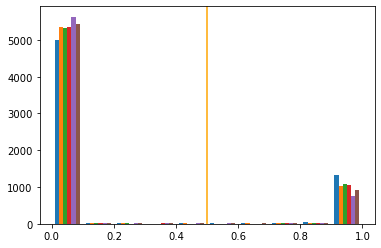

In [65]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [66]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
"{:0.2f}".format(pct_auc)

'99.66'

In [67]:
y_pred_classes = y_hat.round()
acc = score(y_valid, y_pred_classes) * 100
"{:0.2f}".format(acc)

'96.22'

In [68]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [69]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [70]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
